In [16]:

# Second cell: Import required libraries
import json
import random
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from joblib import dump
import string


In [17]:

# Third cell: Download necessary NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kastu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kastu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kastu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [18]:

# Fourth cell: Load intents data
with open('dataset/information_intents.json', 'r') as f:
    information_intents = json.load(f)

with open('dataset/events_intents.json', 'r') as f:
    events_intents = json.load(f)

with open('dataset/support_intents.json', 'r') as f:
    support_intents = json.load(f)


In [19]:

# Fifth cell: Combine all intents
all_intents = information_intents['intents'] + events_intents['intents'] + support_intents['intents']

lemmatizer = WordNetLemmatizer()


In [20]:

# Sixth cell: Function to get WordNet POS tag
def get_wordnet_pos(word, tag):
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag[0], wordnet.NOUN)


In [21]:
def synonym_replacement(sentence, n=1):
    words = word_tokenize(sentence)
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in string.punctuation]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = []
        for syn in wordnet.synsets(random_word):
            for lemma in syn.lemmas():
                synonyms.append(lemma.name())
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n:
            break
    
    return ' '.join(new_words)

# Random deletion
def random_deletion(sentence, p=0.1):
    words = word_tokenize(sentence)
    if len(words) == 1:
        return sentence
    
    new_words = []
    for word in words:
        if random.uniform(0, 1) > p:
            new_words.append(word)
    
    if len(new_words) == 0:
        rand_int = random.randint(0, len(words)-1)
        return words[rand_int]
    
    return ' '.join(new_words)

# Word order change
def word_order_change(sentence):
    words = word_tokenize(sentence)
    if len(words) <= 3:
        return sentence
    
    new_words = words.copy()
    for _ in range(min(1, len(words)//4)):  
        idx1 = random.randint(0, len(words)-2)
        idx2 = random.randint(0, len(words)-2)
        new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]
    
    return ' '.join(new_words)


In [22]:


# Eighth cell: Function to augment training data
def augment_training_data(intents, augment_factor=2):
    X_train = []
    y_train = []
    
    for intent in intents:
        original_patterns = intent["patterns"]
        
        for pattern in original_patterns:
            X_train.append(pattern)
            y_train.append(intent["tag"])
        
        for pattern in original_patterns:
            if len(pattern.split()) > 3:
                for _ in range(augment_factor):
                    augmented = synonym_replacement(pattern)
                    X_train.append(augmented)
                    y_train.append(intent["tag"])
                
                for _ in range(augment_factor):
                    augmented = random_deletion(pattern)
                    X_train.append(augmented)
                    y_train.append(intent["tag"])
                
                for _ in range(augment_factor):
                    augmented = word_order_change(pattern)
                    X_train.append(augmented)
                    y_train.append(intent["tag"])
    
    return X_train, y_train


In [23]:

# Ninth cell: Data preparation with augmentation
X_train, y_train = augment_training_data(all_intents)


In [24]:

# Tenth cell: Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [25]:

# Eleventh cell: Convert text data into numerical form
vectorizer = CountVectorizer(ngram_range=(1, 2))  # Include bigrams
X_train_vectors = vectorizer.fit_transform(X_train)
X_val_vectors = vectorizer.transform(X_val)


In [26]:

# Twelfth cell: Hyperparameter tuning for Naive Bayes
param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0], 'fit_prior': [True, False]}

grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_vectors, y_train)

print(f"Best parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_


C:\Users\kastu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'alpha': 1.5, 'fit_prior': False}


In [27]:

# Thirteenth cell: Evaluate on validation set
val_accuracy = best_model.score(X_val_vectors, y_val)
print(f"Validation accuracy: {val_accuracy:.4f}")


Validation accuracy: 0.7903


In [28]:

# Fourteenth cell: Train final model on all data
X_all_vectors = vectorizer.fit_transform(X_train + X_val)
y_all = y_train + y_val

final_model = MultinomialNB(**grid_search.best_params_)
final_model.fit(X_all_vectors, y_all)


MultinomialNB(alpha=1.5, fit_prior=False)

In [29]:

# Fifteenth cell: Save model and vectorizer
dump(final_model, 'model/chatbot_model.joblib')
dump(vectorizer, 'model/vectorizer.joblib')

print("Model training complete. Saved to 'model/chatbot_model.joblib'.")


Model training complete. Saved to 'model/chatbot_model.joblib'.


In [30]:
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Predict on validation set
y_pred = best_model.predict(X_val_vectors)

# Step 2: Compare predictions with actual values
misclassified_indices = np.where(y_pred != y_val)[0]

# Step 3: Print misclassified examples
print(f"Number of misclassified examples: {len(misclassified_indices)}\n")
for index in misclassified_indices:
    print(f"True label: {y_val[index]} | Predicted label: {y_pred[index]} | Pattern: {X_val[index]}")

# Step 4: Evaluate model performance
print("\nClassification Report:\n", classification_report(y_val, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))

Number of misclassified examples: 13

True label: financial_aid_help | Predicted label: tuition | Pattern: Tuition payment issues
True label: technical_support | Predicted label: academic_advising | Pattern: Password reset help
True label: housing_issues | Predicted label: academic_advising | Pattern: Residence hall maintenance
True label: financial_aid_help | Predicted label: academic_advising | Pattern: Payment plan options
True label: course_details | Predicted label: academic_advising | Pattern: Course information
True label: academic_programs | Predicted label: course_details | Pattern: Available courses
True label: mental_health | Predicted label: academic_advising | Pattern: Counseling services
True label: academic_calendar | Predicted label: academic_advising | Pattern: Holiday breaks
True label: financial_aid_help | Predicted label: admissions_general | Pattern: Scholarship application help
True label: workshops | Predicted label: upcoming_events | Pattern: Professional develo

C:\Users\kastu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kastu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kastu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

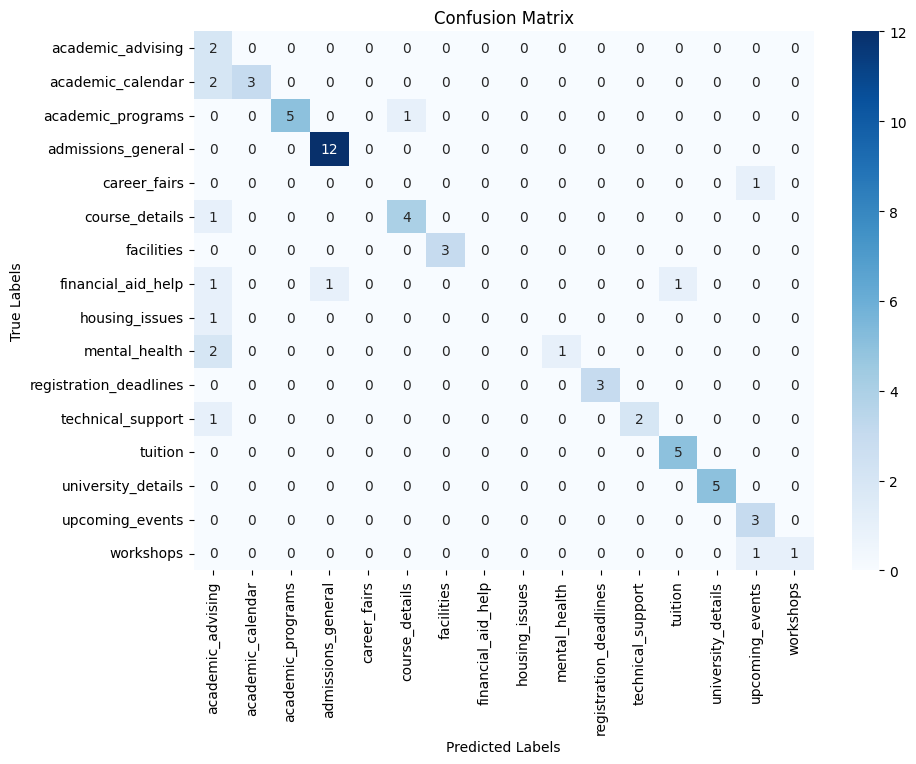

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Step 1: Get confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Step 2: Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()